In [1]:
import os
import sys
import logging
import torch
import transformers
import datasets

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, 'src'))

logging.basicConfig(level=logging.INFO)

In [2]:
BERT = 'BERT'
GPT = 'GPT2'
BERT_CONTEXT_SIZE=512
GPT_CONTEXT_SIZE=1024
device='cuda'


In [3]:
wiki = datasets.load_dataset('wikipedia', '20220301.en', split='train')
wiki = wiki.filter(lambda x: len(x['text']) > 2000) # Only long articles

In [4]:
import numpy as np

class WikiDataset(torch.utils.data.Dataset):
    def __init__(self, model_type, dataset_size, context_size, wiki_dataset, seed=42):
        super().__init__()
        self.dataset_size = dataset_size
        self.model_type = model_type
        self.context_size = context_size
        self.rng = np.random.RandomState(seed)
        
        self.wiki = wiki_dataset
        if model_type == GPT:
            self.tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2-large")
        else:
            self.tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')
        self.X = torch.tensor(self._construct_dataset())

    def __getitem__(self, idx):
        return self.X[idx]

    def __len__(self):
        return self.dataset_size

    def _construct_dataset(self):
        X = []
        for i in range(self.dataset_size):
            if self.model_type == BERT:
                random_sentence1 = self._random_sentence(self.context_size-2)
                random_sentence2 = self._random_sentence(self.context_size-2)
                len1 = self.rng.randint(5, self.context_size-2-5)
                len2 = self.context_size - 2 - len1
                if self.rng.uniform() < 0.5:
                    random_sentence1 = random_sentence1[:len1]
                    random_sentence2 = random_sentence2[:len2]
                else:
                    random_sentence1, random_sentence2 = random_sentence1[:len1], random_sentence1[len1:]
                
                tokenized = [self.tokenizer.cls_token_id] + random_sentence1 + [self.tokenizer.sep_token_id] + random_sentence2
                assert len(tokenized) == self.context_size, len(tokenized)
            else:
                tokenized = self._random_sentence(self.context_size)
            X.append(tokenized)
        return X
    def _random_sentence(self, sz):
        while True:
            doc_id = self.rng.randint(0, len(self.wiki))
            doc_content = self.wiki[doc_id]['text']
            doc_tokenized = self.tokenizer(doc_content, add_special_tokens=False).input_ids
            if len(doc_tokenized) >= 1.5 * self.context_size: # Long enough articles
                break
        start_idx = self.rng.randint(0, len(doc_tokenized) - sz)
        tokenized = doc_tokenized[start_idx:start_idx + sz]
        return tokenized

In [5]:
gpt_dataset = WikiDataset(model_type=GPT, dataset_size=2000, context_size=GPT_CONTEXT_SIZE, wiki_dataset=wiki)
bert_dataset = WikiDataset(model_type=BERT, dataset_size=2000, context_size=BERT_CONTEXT_SIZE, wiki_dataset=wiki)

Token indices sequence length is longer than the specified maximum sequence length for this model (1810 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


In [6]:
trained_bert = transformers.BertModel.from_pretrained('bert-large-uncased')
trained_gpt2_model = transformers.GPT2Model.from_pretrained('gpt2-large')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
untrained_bert = transformers.BertModel(trained_bert.config, add_pooling_layer=trained_bert is not None)
untrained_gpt = transformers.GPT2Model(trained_gpt2_model.config)

In [8]:
trained_bert.eval()
trained_gpt2_model.eval()
untrained_bert.eval()
untrained_gpt.eval()

GPT2Model(
  (wte): Embedding(50257, 1280)
  (wpe): Embedding(1024, 1280)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPT2Block(
      (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): GPT2Block(
      (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1280,), eps=1e-05, elem

In [9]:
from tqdm import tqdm
def get_model_outs(model, dataset):
    model = model.to(device)
    data_loader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=2)
    result = {
        'embedded': [],
        'encoded': [],
    }
    for X in tqdm(data_loader):
        with torch.no_grad():
            X = X.to(device)
            model_out = model(
                input_ids=X,
                output_hidden_states=True,
                output_attentions=True,
                use_cache=False,
            )
            result['embedded'].append(model_out.hidden_states[0].detach().clone().cpu())
            result['encoded'].append(model_out.hidden_states[1].detach().clone().cpu()) 
    for k in result.keys():
        if result[k]:
            result[k] = torch.concat(result[k], dim=0)
    model = model.to('cpu')
    return result


### Warning: The following lines are memory intensive, it is better to run them one by one, and then proceed by loading from the disk.

In [10]:
# outputs = {
#     'trained_gpt2': get_model_outs(trained_gpt2_model, gpt_dataset),
#     'untrained_gpt': get_model_outs(untrained_gpt, gpt_dataset),
#     'trained_bert': get_model_outs(trained_bert, bert_dataset),
#     'untrained_bert': get_model_outs(untrained_bert, bert_dataset),
# }
# torch.save(outputs, 'trained_gpt2_outputs.ckpt')
# torch.save(outputs, 'untrained_gpt_outputs.ckpt')
# torch.save(outputs, 'trained_bert_outputs.ckpt')
# torch.save(outputs, 'untrained_bert_outputs.ckpt')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.13it/s]


In [10]:
raise Exception("No Further")

Exception: No Further

# Since it takes to much RAM, from here, we load the computed ones from the disk

In [3]:
outputs = {}
for file_name in ['trained_gpt2_outputs', 'untrained_gpt_outputs', 'trained_bert_outputs', 'untrained_bert_outputs']:
    outputs.update(torch.load(f'{file_name}.ckpt'))

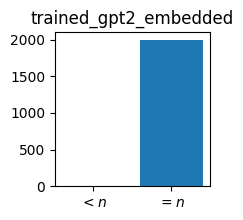

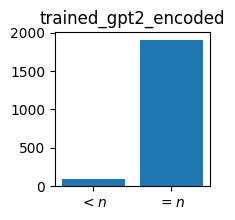

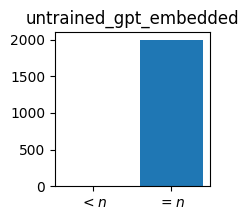

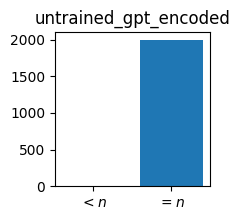

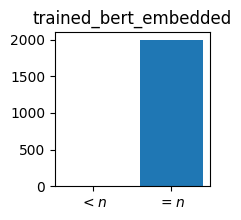

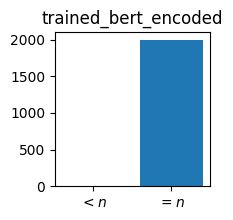

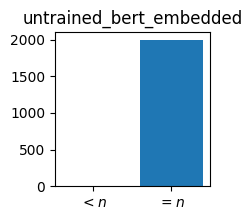

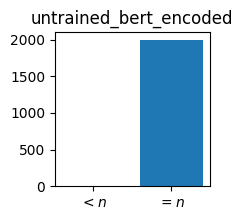

In [4]:
import matplotlib.pyplot as plt

def get_context_ranks(arr):
    # get the ranks of the context
    T, n, d = arr.shape
    ranks = []
    for i in range(T):
        context = arr[i]
        ranks.append(torch.linalg.matrix_rank(context))
    return torch.tensor(ranks)

for model_name, output_dict in outputs.items():
    for key, arr in output_dict.items():
        n = arr.shape[1]
        ranks = get_context_ranks(arr)
        plt.figure(figsize=(2, 2))
        plt.bar(['$<n$', '$=n$'], [sum([r < n for r in ranks]), sum([r == n for r in ranks])])
        plt.title(f'{model_name}_{key}')
        plt.show()


In [6]:
from tqdm import tqdm

def minimal_check_n_kruskal_rank(arr, n_rank, total_exps=5000, device='cpu'):
    arr = arr.to(device)
    T = arr.shape[0]
    cnt = 0
    rank_dist = {}
    for _ in tqdm(range(total_exps)):
        random_perm = torch.randperm(T)[:n_rank]
        sample = arr[random_perm, :]
        rank = torch.linalg.matrix_rank(sample).item()
        if rank == n_rank:
            cnt += 1
        rank_dist[rank] = rank_dist.get(rank, 0) + 1
    return cnt / total_exps, rank_dist

In [ ]:
for model_name, output_dict in outputs.items():
    for key, arr in output_dict.items():
        b, n, d = arr.shape
        query_idx = 0 if 'bert' in model_name else -1
        cls_token = arr[:, query_idx, :]
        for kruskal_candid, candid_name in zip([n, d], ['n', 'd']):
            satisfied_percent, _ = minimal_check_n_kruskal_rank(cls_token, kruskal_candid)
            print(f'{model_name}_{key}, candid={candid_name}, fraction satisfied={satisfied_percent}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:44<00:00, 14.53it/s]


trained_gpt2_embedded, candid=n, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:16<00:00, 13.29it/s]


trained_gpt2_embedded, candid=d, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:52<00:00, 14.19it/s]


trained_gpt2_encoded, candid=n, fraction satisfied=1.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:28<00:00, 12.87it/s]


trained_gpt2_encoded, candid=d, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:41<00:00, 14.63it/s]


untrained_gpt_embedded, candid=n, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:18<00:00, 13.23it/s]


untrained_gpt_embedded, candid=d, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:50<00:00, 14.28it/s]


untrained_gpt_encoded, candid=n, fraction satisfied=1.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:25<00:00, 12.96it/s]


untrained_gpt_encoded, candid=d, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:42<00:00,  6.56it/s]


trained_bert_embedded, candid=n, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:34<00:00, 14.96it/s]


trained_bert_embedded, candid=d, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 69.19it/s]


trained_bert_encoded, candid=n, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:58<00:00, 20.97it/s]


trained_bert_encoded, candid=d, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:36<00:00,  7.18it/s]


untrained_bert_embedded, candid=n, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:42<00:00, 17.70it/s]


untrained_bert_embedded, candid=d, fraction satisfied=0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:13<00:00, 68.09it/s]


untrained_bert_encoded, candid=n, fraction satisfied=0.0


 55%|███████████████████████████████████████████████████████████████████████▌                                                           | 2730/5000 [02:12<01:49, 20.73it/s]

In [10]:
model_name = untrained_bert
outputs['untrained_bert']['embedded'].shape

torch.Size([2000, 512, 1024])

## Kruskal Rank of BERT

In [17]:
for key, ranges in reversed(list(zip(['trained_bert', 'untrained_bert'], [range(290, 305), range(340, 355)]))):
    print(key)
    for n in ranges:
        print('testing n=', n)
        print(minimal_check_n_kruskal_rank(outputs[key]['encoded'][:, 0, :], n, total_exps=5000))
    print('-'*10)

untrained_bert
testing n= 340


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 120.75it/s]


(0.9998, {340: 4999, 339: 1})
testing n= 341


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.74it/s]


(1.0, {341: 5000})
testing n= 342


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 107.09it/s]


(1.0, {342: 5000})
testing n= 343


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 106.50it/s]


(0.9998, {343: 4999, 342: 1})
testing n= 344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 107.27it/s]


(0.999, {344: 4995, 343: 5})
testing n= 345


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.37it/s]


(0.9986, {345: 4993, 344: 7})
testing n= 346


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.79it/s]


(0.9992, {346: 4996, 345: 4})
testing n= 347


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.74it/s]


(0.9984, {347: 4992, 346: 8})
testing n= 348


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 107.57it/s]


(0.9956, {348: 4978, 347: 22})
testing n= 349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 104.80it/s]


(0.9928, {349: 4964, 348: 36})
testing n= 350


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 104.40it/s]


(0.9878, {350: 4939, 349: 61})
testing n= 351


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 134.24it/s]


(0.9822, {351: 4911, 350: 89})
testing n= 352


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 135.44it/s]


(0.967, {352: 4835, 351: 165})
testing n= 353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 132.14it/s]


(0.955, {352: 222, 353: 4775, 351: 3})
testing n= 354


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 130.78it/s]


(0.9318, {354: 4659, 353: 339, 352: 2})
----------
trained_bert
testing n= 290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 146.29it/s]


(0.9996, {290: 4998, 289: 2})
testing n= 291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 145.30it/s]


(0.9996, {291: 4998, 290: 2})
testing n= 292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 145.79it/s]


(0.9992, {292: 4996, 291: 4})
testing n= 293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 142.79it/s]


(0.9996, {293: 4998, 292: 2})
testing n= 294


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 142.17it/s]


(0.9986, {294: 4993, 293: 7})
testing n= 295


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 141.35it/s]


(0.9964, {295: 4982, 294: 18})
testing n= 296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 142.41it/s]


(0.9952, {296: 4976, 295: 24})
testing n= 297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 139.36it/s]


(0.9922, {297: 4961, 296: 39})
testing n= 298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 140.90it/s]


(0.9834, {298: 4917, 297: 83})
testing n= 299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 140.28it/s]


(0.9696, {299: 4848, 298: 151, 297: 1})
testing n= 300


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 141.42it/s]


(0.9554, {300: 4777, 299: 222, 298: 1})
testing n= 301


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 138.69it/s]


(0.9232, {301: 4616, 300: 383, 299: 1})
testing n= 302


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 137.55it/s]


(0.88, {302: 4400, 301: 596, 300: 4})
testing n= 303


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 136.60it/s]


(0.8344, {303: 4172, 302: 821, 301: 7})
testing n= 304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 137.45it/s]

(0.767, {304: 3835, 303: 1142, 302: 23})
----------
